## **Make some preparations for work**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir('../input'))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir('/kaggle/working/'))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '__MACOSX', '.virtual_documents']


In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
import time
import copy
import random
import shutil

import cv2
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [5]:
DATA_ROOT = '/kaggle/working/plates/'
TRAIN_DIR = 'train'
TEST_DIR = 'test'

In [6]:
shutil.copytree(os.path.join(DATA_ROOT, TRAIN_DIR), TRAIN_DIR)

'train'

In [7]:
shutil.copytree(os.path.join(DATA_ROOT, TEST_DIR), os.path.join(TEST_DIR, 'unknown'))

'test/unknown'

## **Classes and functions**

In [8]:
class DataPreprocessing:
    """Class for datasets preprocessing"""
    
    def _remove_background(self, path, file):
        # TODO: Improve background removing and crop images
        img = cv2.imread(path + file)
    
        img = np.array(img)
        height, width = img.shape[:2]
        mask = np.zeros([height, width], np.uint8)

        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        rect = (15, 15, width-15, height-15)
        cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
        res = img * mask[:, :, np.newaxis]

        # Get the background
        background = img - res

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        res = np.array(background + res)
        cv2.imwrite(path + file, res)

    def remove_background(self, image_folders):
        for path in image_folders:
            files = os.listdir(path)
            files = list(filter(lambda x: x.endswith('.jpg'), files))

            for file in tqdm(files):
                self._remove_background(path, file)

In [9]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [10]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()

## **Preprocess images**

In [11]:
preprocessor = DataPreprocessing()

In [13]:
# Removing images background
preprocessor.remove_background(image_folders=[
    os.path.join(TRAIN_DIR, 'cleaned/'),
    os.path.join(TRAIN_DIR, 'dirty/'),
    os.path.join(TEST_DIR, 'unknown/')
])

100%|██████████| 744/744 [11:21<00:00,  1.09it/s]


In [14]:
!ls train/cleaned

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


In [15]:
!ls train/dirty

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


## **Transforms for train dataset**

In [16]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=90, fill=255),
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)

In [17]:
len(train_dataloader), len(train_dataset)

(5, 40)

In [18]:
train_transforms

Compose(
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=255)
    CenterCrop(size=(180, 180))
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=(0.1, 0.2))
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

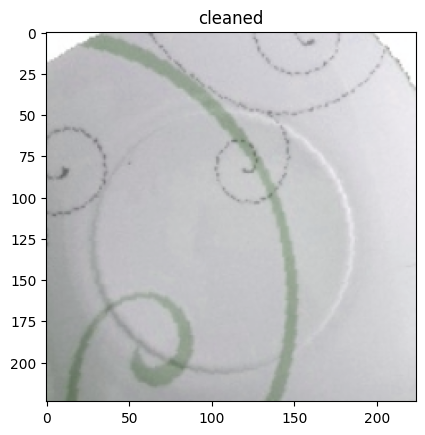

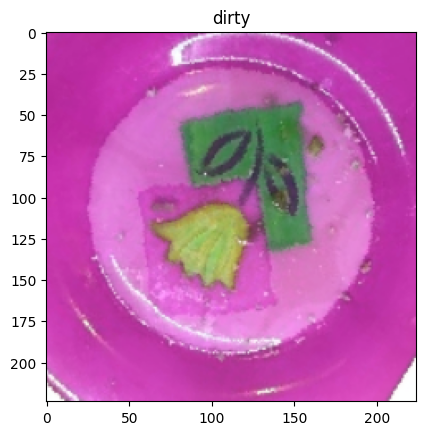

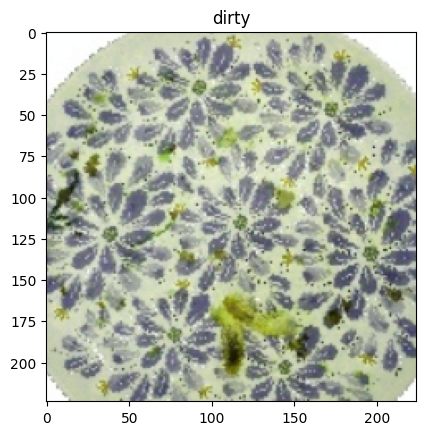

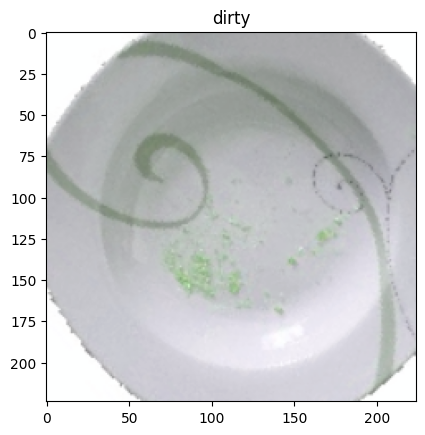

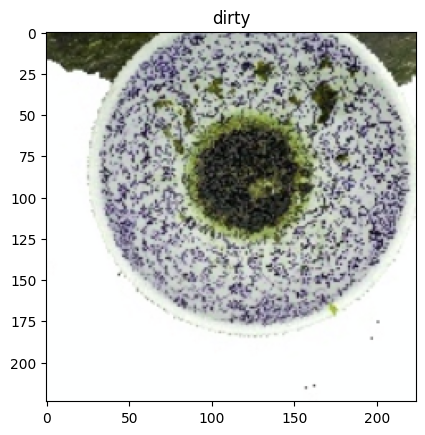

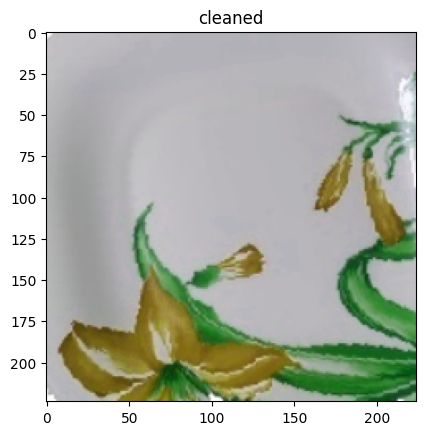

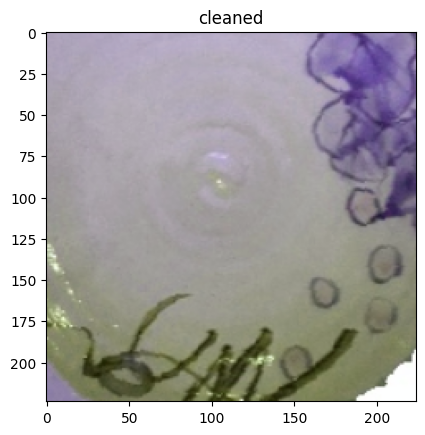

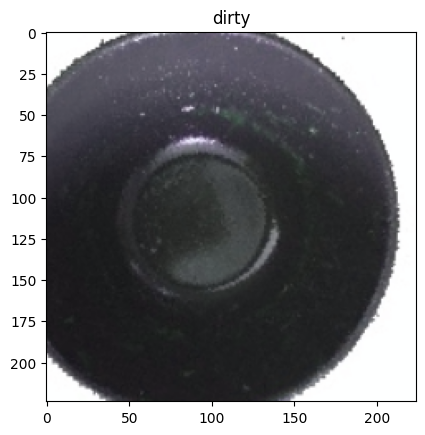

In [19]:
class_names = ['cleaned', 'dirty']

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## **Model training**

In [41]:
def train_model(model, dataloader, loss, optimizer, scheduler, num_epochs):
    accuracies = {'train': []}
    losses = {'train': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training phase
        phase = 'train'
        model.train()  # Set model to training mode

        running_loss = 0.
        running_acc = 0.

        # Iterate over data
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward and backward
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                loss_value.backward()
                optimizer.step()

            # Statistics
            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()
        
        scheduler.step()
            
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        accuracies[phase].append(epoch_acc)
        losses[phase].append(epoch_loss)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, losses, accuracies

In [42]:
# Choose seed for training reproduction
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
model = models.resnet50(pretrained=True)
# model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=1.0)
# optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
model, losses, accuracies = train_model(model, train_dataloader, loss,
                                        optimizer, scheduler, num_epochs=40)

Epoch 0/39:


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

train Loss: 0.7490 Acc: 0.3750
Epoch 1/39:



100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

train Loss: 0.6865 Acc: 0.5750
Epoch 2/39:



100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

train Loss: 0.6311 Acc: 0.6500
Epoch 3/39:



100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

train Loss: 0.5151 Acc: 0.8000
Epoch 4/39:



100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

train Loss: 0.4648 Acc: 0.8500
Epoch 5/39:



100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

train Loss: 0.5699 Acc: 0.6500
Epoch 6/39:



100%|██████████| 5/5 [00:00<00:00,  6.49it/s]

train Loss: 0.4535 Acc: 0.7750
Epoch 7/39:



100%|██████████| 5/5 [00:00<00:00,  5.52it/s]

train Loss: 0.4532 Acc: 0.7750
Epoch 8/39:



100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

train Loss: 0.4466 Acc: 0.8000
Epoch 9/39:



100%|██████████| 5/5 [00:00<00:00,  5.78it/s]

train Loss: 0.2433 Acc: 0.9250
Epoch 10/39:



100%|██████████| 5/5 [00:00<00:00,  6.57it/s]

train Loss: 0.3673 Acc: 0.8000
Epoch 11/39:



100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

train Loss: 0.2995 Acc: 0.8250
Epoch 12/39:



100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

train Loss: 0.5731 Acc: 0.6000
Epoch 13/39:



100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

train Loss: 0.5185 Acc: 0.7250
Epoch 14/39:



100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

train Loss: 0.5014 Acc: 0.7750
Epoch 15/39:



100%|██████████| 5/5 [00:00<00:00,  6.57it/s]

train Loss: 0.4347 Acc: 0.8000
Epoch 16/39:



100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

train Loss: 0.3911 Acc: 0.8250
Epoch 17/39:



100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

train Loss: 0.3138 Acc: 0.8000
Epoch 18/39:



100%|██████████| 5/5 [00:00<00:00,  6.71it/s]

train Loss: 0.2813 Acc: 0.9000


Epoch 19/39:


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

train Loss: 0.3105 Acc: 0.8500
Epoch 20/39:



100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

train Loss: 0.3002 Acc: 0.9000
Epoch 21/39:



100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

train Loss: 0.2692 Acc: 0.8750
Epoch 22/39:



100%|██████████| 5/5 [00:00<00:00,  6.17it/s]

train Loss: 0.2794 Acc: 0.9000
Epoch 23/39:



100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

train Loss: 0.2519 Acc: 0.9500
Epoch 24/39:



100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

train Loss: 0.2018 Acc: 0.9500
Epoch 25/39:



100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

train Loss: 0.2337 Acc: 0.9250
Epoch 26/39:



100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

train Loss: 0.1717 Acc: 1.0000
Epoch 27/39:



100%|██████████| 5/5 [00:00<00:00,  6.69it/s]

train Loss: 0.1923 Acc: 0.9500
Epoch 28/39:



100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

train Loss: 0.3395 Acc: 0.8500
Epoch 29/39:



100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

train Loss: 0.2078 Acc: 0.9500
Epoch 30/39:



100%|██████████| 5/5 [00:00<00:00,  6.55it/s]

train Loss: 0.2043 Acc: 0.9250
Epoch 31/39:



100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

train Loss: 0.2740 Acc: 0.9250
Epoch 32/39:



100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

train Loss: 0.3915 Acc: 0.8500
Epoch 33/39:



100%|██████████| 5/5 [00:00<00:00,  6.66it/s]

train Loss: 0.2294 Acc: 0.9000
Epoch 34/39:



100%|██████████| 5/5 [00:00<00:00,  6.35it/s]

train Loss: 0.2294 Acc: 0.9000
Epoch 35/39:



100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

train Loss: 0.1916 Acc: 0.9500
Epoch 36/39:



100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


train Loss: 0.2683 Acc: 0.9250
Epoch 37/39:


100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

train Loss: 0.2234 Acc: 0.9500
Epoch 38/39:



100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

train Loss: 0.2615 Acc: 0.8500
Epoch 39/39:



100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

train Loss: 0.2121 Acc: 0.9250


Text(0.5, 1.0, 'Loss')

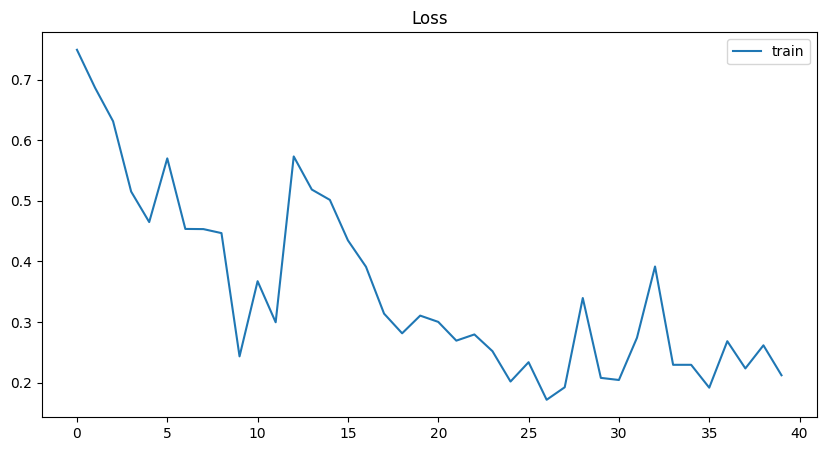

In [24]:
plt.rcParams['figure.figsize'] = (10, 5)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss')

## **Transforms for test dataset**

In [25]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

test_dataset = ImageFolderWithPaths(os.path.join(TEST_DIR), transform=test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=0
)

In [26]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(180, 180))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

## **Make predictions for test dataset**

In [27]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 28.81it/s]


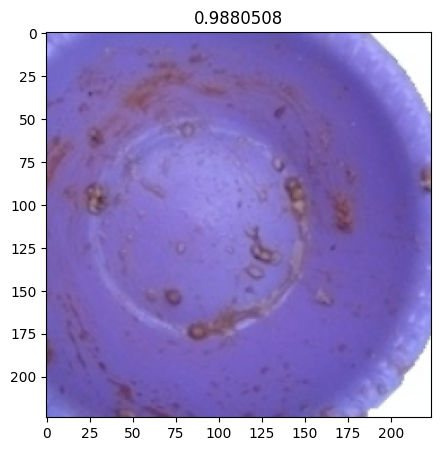

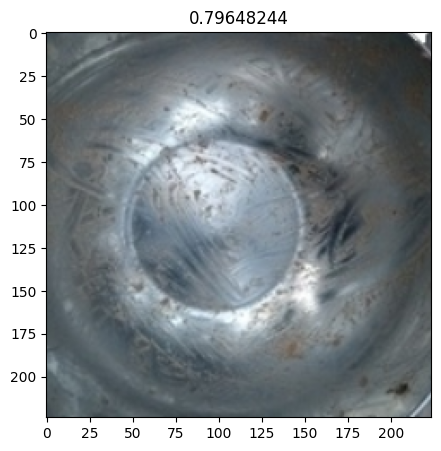

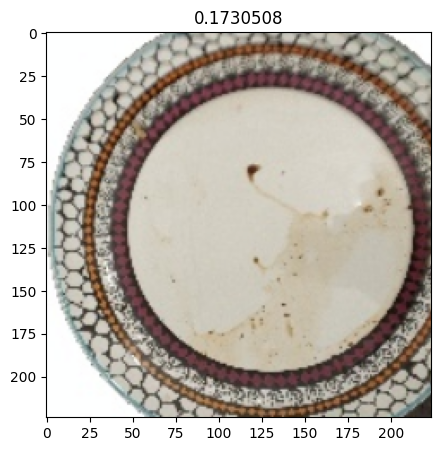

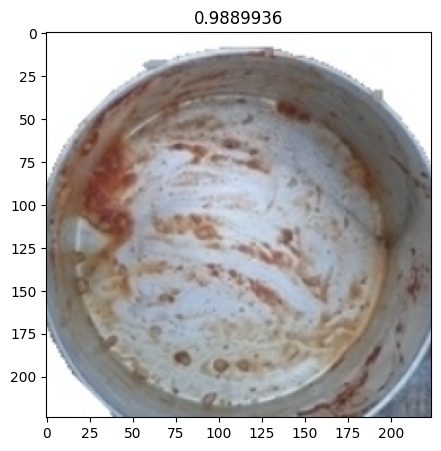

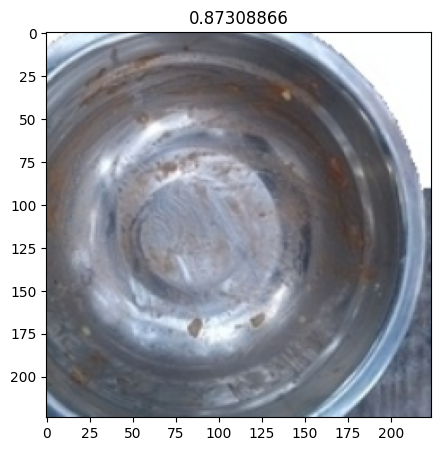

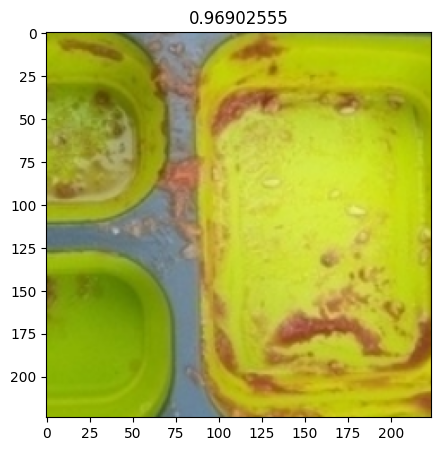

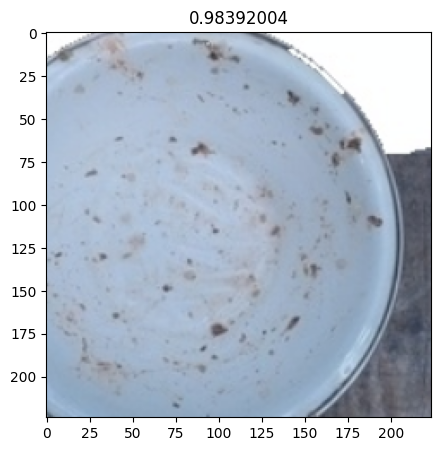

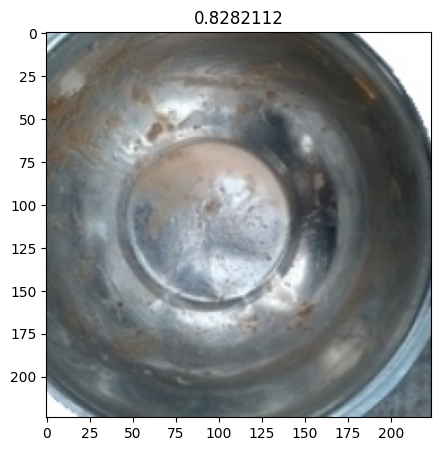

In [28]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)